In [5]:
import cv2
import numpy as np
import pickle
import os
from os.path import join, isfile, exists, isdir, dirname
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
dataset_path = '../sample-data/dataset_synthesize.xlsx'
data_dir = '../sample-data'

export_dir_prefix = '../outputs/'
export_excel_path = '../outputs/motion-compensation.xlsx'
export_mp4_dir = '../outputs/mp4-outputs'

ROI_margin_suffix_list = ['withoutROImargin']  #['withROImargin', 'withoutROImargin']
frame_rate_suffix_list = ['fullFrameRate']  #['halfFrameRate', 'fullFrameRate']

fixed_size_ROI = False  #if True, the output ROIs will have a fixed size, rather than fitted to the lesion

set_quantile = 0.50  #initial quantile
threshold_decrease_per_step = 0.02

# functions

In [7]:
def add_data_dir(x, data_dir):
    if pd.isna(x):
        return None
    else:
        return join(data_dir, x)



def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    print(data.shape)

    return data



def find_ref_frames_from_nifti(nifti_path, ROI_margin_suffix, search_margin):
    
    nifti_array = np.transpose(nib.load(nifti_path).get_fdata()).astype(int)
    print(nifti_array.shape)  # expected (frames, height, width)

    spatial_sum = np.sum(nifti_array, axis=(1, 2))  # shape (frames,)
    ref_frames = np.argwhere(spatial_sum > 0)
    ref_frames = np.reshape(ref_frames, ref_frames.shape[0])

    if ROI_margin_suffix == 'withROImargin':
        ROI_margin = int(search_margin/2)
    elif ROI_margin_suffix == 'withoutROImargin':
        ROI_margin = 0
    
    bboxes = []
    masks = []
    for i,ref_frame in enumerate(ref_frames):
        mask = nifti_array[ref_frame]
        pos_coor = np.argwhere(mask > 0)
        x_values = pos_coor[:, 1]
        y_values = pos_coor[:, 0]
        x0 = x_values.min()
        x1 = x_values.max()
        w = x1 - x0 + 1
        y0 = y_values.min()
        y1 = y_values.max()
        h = y1 - y0 + 1
        
        bboxes.append((x0-ROI_margin,
                       y0-ROI_margin,
                       w+(2*ROI_margin),
                       h+(2*ROI_margin)))
        masks.append(mask[y0-ROI_margin:y0-ROI_margin+h+(2*ROI_margin), 
                          x0-ROI_margin:x0-ROI_margin+w+(2*ROI_margin)])

    return ref_frames, bboxes, masks



def export_video(cine_array, mp4_path, CineRate):

    mp4_dir = dirname(mp4_path)
    if not exists(mp4_dir):
        os.makedirs(mp4_dir)

    width = cine_array.shape[2]
    height = cine_array.shape[1]
    if pd.notna(CineRate):
        frame_rate = int(CineRate)
    else:
        print('no CineRate in excel file; using default frame rate = 9')
        frame_rate = 9

    writer = cv2.VideoWriter(mp4_path, cv2.VideoWriter_fourcc(*'XVID'), frame_rate, (width, height))

    if len(cine_array.shape) == 3:  # grayscale
        for frame in range(cine_array.shape[0]):
            writer.write(cv2.cvtColor(cine_array[frame], cv2.COLOR_GRAY2BGR))
    elif len(cine_array.shape) == 4:  # RGB
        for frame in range(cine_array.shape[0]):
            writer.write(cine_array[frame])
    else:
        print('color channel not compatible for video exporting; please check dimension of array.')

    writer.release()
    
    
    
def apply_blur(cine_array):
    out = np.zeros(cine_array.shape)
    for frame in range(cine_array.shape[0]):
        img = cine_array[frame]
        img = cv2.GaussianBlur(img, (21, 21), 0)
        out[frame] = img
    out = out.astype(np.uint8)
    return out



def plot_correlation(corr_with_ref, threshold):
    plt.figure(figsize=(24,6))
    plt.axhline(threshold, color='b')
    plt.plot(range(len(corr_with_ref)), corr_with_ref, marker='o', color='g', label='corr_with_ref')
    plt.ylim(0,1.0)
    plt.ylabel('corr_coef')
    plt.xlabel('frame')
    plt.legend()
    plt.show()
    
    
    
def find_correlation(bmode, ref_bmodes, set_quantile):
    
    n_refs = len(ref_bmodes)
    n_frames = bmode.shape[0]
    correlations = np.zeros((n_refs, n_frames))
    
    for ref_idx in range(n_refs):
        ref = ref_bmodes[ref_idx]
        for frame in range(n_frames):
            similarity_map = cv2.matchTemplate(bmode[frame], ref, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(similarity_map)
            correlations[ref_idx, frame] = max_val
            
    correlations = np.mean(correlations, axis=0)
    threshold = np.quantile(correlations, set_quantile)
    
    return correlations, threshold



def check_bbox_move(previous_all_lesion_bboxes, all_lesion_bboxes):
    
    bbox_move = False
    
    for frame in range(len(previous_all_lesion_bboxes)):
        previous_bbox = previous_all_lesion_bboxes[frame]
        current_bbox = all_lesion_bboxes[frame]
        if not(previous_bbox is None):
            if not(previous_bbox == current_bbox):
                bbox_move = True
                break
    
    return bbox_move



def compute_similarity_map(search_region, ref_patches, current_ref_idx):
    
    n_refs = len(ref_patches)
    corrs = np.zeros((n_refs,))
    
    for ref_idx in range(n_refs):
        ref = ref_patches[ref_idx]
        similarity_map = cv2.matchTemplate(search_region, ref, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(similarity_map)
        corrs[ref_idx] = max_val
        if current_ref_idx == ref_idx:
            current_max_loc = max_loc
            
    mean_corr = np.mean(corrs)
            
    return mean_corr, current_max_loc



def resize_MC_bboxes(bboxes):
    #resize bboxes to minimum width and height
    
    min_w = min([b[2] for b in bboxes if not(b is None)])
    min_h = min([b[3] for b in bboxes if not(b is None)])
    
    for i in range(len(bboxes)):
        if bboxes[i] is None:
            continue
        x0, y0, w, h = bboxes[i]
        new_w = min_w
        new_h = min_h
        new_x0 = x0 + int((w-new_w)/2)
        new_y0 = y0 + int((h-new_h)/2)
        bboxes[i] = (new_x0, new_y0, new_w, new_h)
        
    return bboxes



def create_CE_MC_bboxes(bmode_bboxes, x0_bmode, x0_CE, CE_side):
    
    CE_bboxes = [None] * len(bmode_bboxes)
    
    for i in range(len(bmode_bboxes)):
        if bmode_bboxes[i] is None:
            continue
        x0, y0, w, h = bmode_bboxes[i]
        
        if CE_side == 'r':
            new_x0 = x0 + (x0_CE-x0_bmode)
        elif CE_side == 'l':
            new_x0 = x0 - (x0_bmode-x0_CE)
        else:
            raise Exception('Error in create_CE_MC_bboxes')
            
        CE_bboxes[i] = (new_x0, y0, w, h)
    
    return CE_bboxes



def create_segmentation_masks(ref_frames, ref_masks, n_frames):
    
    min_h = min([m.shape[0] for m in ref_masks])
    min_w = min([m.shape[1] for m in ref_masks])
    
    seg_masks = np.zeros((n_frames, min_h, min_w))
    
    for ref_idx in range(ref_frames.shape[0]):
        ref_frame = ref_frames[ref_idx]
        
        #compute the temporal segment the ref_frame is responsible for
        if ref_idx == 0:
            if ref_idx == ref_frames.shape[0] - 1:
                #There is only 1 ref_frame
                ref_begin = 0
                ref_end = n_frames
            else:
                #This is the first ref_frame. There are >1 ref frames.
                ref_begin = 0
                ref_end = int((ref_frames[ref_idx]+ref_frames[ref_idx+1])/2)
        else:
            if ref_idx == ref_frames.shape[0] - 1:
                #This is the last ref frame. There are >1 ref frames.
                ref_begin = int((ref_frames[ref_idx-1]+ref_frames[ref_idx])/2)
                ref_end = n_frames
            else:
                #These are ref frames in the middle. There are >1 ref frames.
                ref_begin = int((ref_frames[ref_idx-1]+ref_frames[ref_idx])/2)
                ref_end = int((ref_frames[ref_idx]+ref_frames[ref_idx+1])/2)
        
        ref_mask = ref_masks[ref_idx]
        h = ref_mask.shape[0]
        w = ref_mask.shape[1]
        x0 = int((w-min_w)/2)
        y0 = int((h-min_h)/2)
        
        seg_masks[ref_begin:ref_end] = ref_mask[y0:y0+min_h, x0:x0+min_w]   #broadcast
        
    return seg_masks



def create_segmentation_masks200(ref_frames, ref_masks, n_frames, ROI_w, ROI_h):
    
    min_h = min([m.shape[0] for m in ref_masks])
    min_w = min([m.shape[1] for m in ref_masks])
    
    seg_masks = np.zeros((n_frames, ROI_h, ROI_w))
    
    for ref_idx in range(ref_frames.shape[0]):
        ref_frame = ref_frames[ref_idx]
        
        #compute the temporal segment the ref_frame is responsible for
        if ref_idx == 0:
            if ref_idx == ref_frames.shape[0] - 1:
                #There is only 1 ref_frame
                ref_begin = 0
                ref_end = n_frames
            else:
                #This is the first ref_frame. There are >1 ref frames.
                ref_begin = 0
                ref_end = int((ref_frames[ref_idx]+ref_frames[ref_idx+1])/2)
        else:
            if ref_idx == ref_frames.shape[0] - 1:
                #This is the last ref frame. There are >1 ref frames.
                ref_begin = int((ref_frames[ref_idx-1]+ref_frames[ref_idx])/2)
                ref_end = n_frames
            else:
                #These are ref frames in the middle. There are >1 ref frames.
                ref_begin = int((ref_frames[ref_idx-1]+ref_frames[ref_idx])/2)
                ref_end = int((ref_frames[ref_idx]+ref_frames[ref_idx+1])/2)
        
        ref_mask = ref_masks[ref_idx]
        h = ref_mask.shape[0]
        w = ref_mask.shape[1]
        x0 = int((w-min_w)/2)
        y0 = int((h-min_h)/2)
        
        top_offset = int((ROI_h-min_h)/2)
        left_offset = int((ROI_w-min_w)/2)
        seg_masks[ref_begin:ref_end, top_offset:top_offset+min_h, left_offset:left_offset+min_w] = ref_mask[y0:y0+min_h, x0:x0+min_w]   #broadcast
        
    return seg_masks



def create_ori_bboxes(ref_frames, ref_bboxes, n_frames):
    min_h = min([b[3] for b in ref_bboxes])
    min_w = min([b[2] for b in ref_bboxes])
    
    ori_bboxes = np.zeros((n_frames, 4))
    
    for ref_idx in range(ref_frames.shape[0]):
        ref_frame = ref_frames[ref_idx]
        
        #compute the temporal segment the ref_frame is responsible for
        if ref_idx == 0:
            if ref_idx == ref_frames.shape[0] - 1:
                #There is only 1 ref_frame
                ref_begin = 0
                ref_end = n_frames
            else:
                #This is the first ref_frame. There are >1 ref frames.
                ref_begin = 0
                ref_end = int((ref_frames[ref_idx]+ref_frames[ref_idx+1])/2)
        else:
            if ref_idx == ref_frames.shape[0] - 1:
                #This is the last ref frame. There are >1 ref frames.
                ref_begin = int((ref_frames[ref_idx-1]+ref_frames[ref_idx])/2)
                ref_end = n_frames
            else:
                #These are ref frames in the middle. There are >1 ref frames.
                ref_begin = int((ref_frames[ref_idx-1]+ref_frames[ref_idx])/2)
                ref_end = int((ref_frames[ref_idx]+ref_frames[ref_idx+1])/2)
        
        x0,y0,w,h = ref_bboxes[ref_idx]
        new_w = min_w
        new_h = min_h
        new_x0 = x0 + int((w-new_w)/2)
        new_y0 = y0 + int((h-new_h)/2)
        
        new_bbox = np.array([new_x0, new_y0, new_w, new_h])
        
        ori_bboxes[ref_begin:ref_end] = new_bbox   #broadcast
        
    return ori_bboxes



def create_CE_ori_bboxes(bmode_bboxes, x0_bmode, x0_CE, CE_side):
    CE_bboxes = bmode_bboxes.copy()
        
    if CE_side == 'r':
        CE_bboxes[:,0] = CE_bboxes[:,0] + (x0_CE-x0_bmode)
    elif CE_side == 'l':
        CE_bboxes[:,0] = CE_bboxes[:,0] - (x0_bmode-x0_CE)
    else:
        raise Exception('Error in create_CE_ori_bboxes')
            
    return CE_bboxes



def cut_ROI(full_array, bboxes):
    
    min_w = min([b[2] for b in bboxes if not(b is None)])
    min_h = min([b[3] for b in bboxes if not(b is None)])
    
    ROI = np.zeros((full_array.shape[0], min_h, min_w))
    
    for frame in range(full_array.shape[0]):
        bbox = bboxes[frame]
        if bbox is None:  #skip MC frames without bbox (due to out-of-frame motion)
            continue
        x0,y0,w,h = bbox
        ROI[frame] = full_array[frame, y0:y0+h, x0:x0+w]
    
    return ROI



def cut_ROI200(full_array, bboxes, window_loc):
    
    min_w = min([b[2] for b in bboxes if not(b is None)])
    min_h = min([b[3] for b in bboxes if not(b is None)])
    
    window_x0, window_y0, window_w, window_h = window_loc
    
    cut_h = int(max(0.4*window_h, min_h, min_w))
    cut_w = cut_h
    
    ROI = np.zeros((full_array.shape[0], cut_h, cut_w))
    
    for frame in range(full_array.shape[0]):
        bbox = bboxes[frame]
        if bbox is None:  #skip MC frames without bbox (due to out-of-frame motion)
            continue
        x0,y0,w,h = bbox
        x_center = x0 + int(w/2)
        y_center = y0 + int(h/2)
        valid_w = min(int(x_center+cut_w/2),window_x0+window_w) - max(int(x_center-cut_w/2),window_x0)
        valid_h = min(int(y_center+cut_h/2),window_y0+window_h) - max(int(y_center-cut_h/2),window_y0)
        center_ROI = int(cut_h/2)
        ROI[frame, int(center_ROI-valid_h/2):int(center_ROI+valid_h/2), int(center_ROI-valid_w/2):int(center_ROI+valid_w/2)] = full_array[frame, 
                                max(int(y_center-cut_h/2),window_y0):min(int(y_center+cut_h/2),window_y0+window_h), 
                                max(int(x_center-cut_w/2),window_x0):min(int(x_center+cut_w/2),window_x0+window_w)]
    
    return ROI



def visualize_ROI(bmode_ori_ROI, CE_ori_ROI, bmode_MC_ROI, CE_MC_ROI, seg_masks):
    n_frames = bmode_ori_ROI.shape[0]
    
    for frame in range(min(n_frames,100)):
        print('frame:', frame)
        plt.figure()
        plt.subplot(1,5,1)
        plt.imshow(bmode_ori_ROI[frame], cmap='gray')
        plt.subplot(1,5,2)
        plt.imshow(CE_ori_ROI[frame], cmap='gray')
        plt.subplot(1,5,3)
        plt.imshow(bmode_MC_ROI[frame], cmap='gray')
        plt.subplot(1,5,4)
        plt.imshow(CE_MC_ROI[frame], cmap='gray')
        plt.subplot(1,5,5)
        plt.imshow(seg_masks[frame], cmap='gray')
        plt.axis('off')
        plt.show()
        
        
        
def export_pickle(cine_array, pickle_path):
    
    pickle_dir = dirname(pickle_path)
    if not exists(pickle_dir):
        os.makedirs(pickle_dir)

    with open(pickle_path, 'wb') as wr:
        pickle.dump(cine_array, wr, protocol=4)
        
        
        
def remove_outlier_bboxes(bboxes, full_array):
    
    all_x0 = [b[0] for b in bboxes if not(b is None)]
    median_x0 = np.median(all_x0)
    q1_x0 = np.quantile(all_x0, 0.25)
    q3_x0 = np.quantile(all_x0, 0.75)
    IQR_x0 = q3_x0 - q1_x0
    
    all_y0 = [b[1] for b in bboxes if not(b is None)]
    median_y0 = np.median(all_y0)
    q1_y0 = np.quantile(all_y0, 0.25)
    q3_y0 = np.quantile(all_y0, 0.75)
    IQR_y0 = q3_y0 - q1_y0
    
    out_bboxes = [None]*len(bboxes)
    outliers = [None]*len(bboxes)
    for i,b in enumerate(bboxes):
        if not(b is None):
            if (b[0]>=q1_x0-(1.5*IQR_x0)) and (b[0]<=q3_x0+(1.5*IQR_x0)) and \
            (b[1]>=q1_y0-(1.5*IQR_y0)) and (b[1]<=q3_y0+(1.5*IQR_y0)):
                out_bboxes[i] = b[:]
            else:
                outliers[i] = b[:]
                
    print('usable bboxes:', len([b for b in out_bboxes if not(b is None)]))
    print('outlier bboxes:', len([b for b in outliers if not(b is None)]))
    
    return out_bboxes



def perform_MC(pickle_full_path, nifti_segmentation_path, mp4_path,
              ROI_margin_suffix, frame_rate_suffix):
    
    if frame_rate_suffix == 'fullFrameRate':
        step = 1
    elif frame_rate_suffix == 'halfFrameRate':
        step = 2
    
    full_array = load_pickle(pickle_full_path).astype(np.uint8)
    
    full_h = full_array.shape[1]
    search_margin = int((0.5/15)*full_h)

    ref_frames, bboxes, masks = find_ref_frames_from_nifti(nifti_segmentation_path, ROI_margin_suffix, search_margin)

    #############################################################
    #find initial correlation in the first run
    min_x0 = min([e[0] for e in bboxes]) - search_margin
    max_x1 = max([e[0]+e[2] for e in bboxes]) + search_margin
    min_y0 = min([e[1] for e in bboxes]) - search_margin
    max_y1 = max([e[1]+e[3] for e in bboxes]) + search_margin
    bmode = full_array[:,
                  min_y0:max_y1,
                  min_x0:max_x1]
    ref_bmodes = []
    for ri in range(ref_frames.shape[0]):
        ref_f = ref_frames[ri]
        ref_b = bboxes[ri]
        ref_bmodes.append(full_array[ref_f,
                                    ref_b[1]:ref_b[1]+ref_b[3],
                                    ref_b[0]:ref_b[0]+ref_b[2]])
    corr_initial_run, threshold = find_correlation(bmode, ref_bmodes, set_quantile)
    print('initial threshold:', threshold)
    ############################################################
    
    ref_patches = ref_bmodes[:]
    
    previous_all_lesion_bboxes = [None]*full_array.shape[0]
    iteration = 1
        
    while True:
        
        out_array = np.zeros(list(full_array.shape)+[3], dtype=np.uint8)
        
        all_search_bboxes = [None]*full_array.shape[0]
        all_lesion_bboxes = [None]*full_array.shape[0]
        corr_with_ref = [None]*full_array.shape[0]
    
        for ref_idx in range(ref_frames.shape[0]):
            ref_frame = ref_frames[ref_idx]
            ref_bbox = bboxes[ref_idx]

            #show location of the ref_bbox
            if iteration == 1 and ref_idx==0:
                img_bbox = cv2.rectangle(cv2.cvtColor(full_array[ref_frame], cv2.COLOR_GRAY2BGR),
                                             (ref_bbox[0], ref_bbox[1]),
                                             (ref_bbox[0] + ref_bbox[2], ref_bbox[1] + ref_bbox[3]),
                                             (0, 255, 0), 5)
                plt.imshow(img_bbox)
                plt.show()

            #compute the temporal segment the ref_frame is responsible for
            #######################
            if ref_idx == 0:
                if ref_idx == ref_frames.shape[0] - 1:
                    #There is only 1 ref_frame
                    ref_begin = 0
                    ref_end = full_array.shape[0]
                else:
                    #This is the first ref_frame. There are >1 ref frames.
                    ref_begin = 0
                    ref_end = int((ref_frames[ref_idx]+ref_frames[ref_idx+1])/2)
            else:
                if ref_idx == ref_frames.shape[0] - 1:
                    #This is the last ref frame. There are >1 ref frames.
                    ref_begin = int((ref_frames[ref_idx-1]+ref_frames[ref_idx])/2)
                    ref_end = full_array.shape[0]
                else:
                    #These are ref frames in the middle. There are >1 ref frames.
                    ref_begin = int((ref_frames[ref_idx-1]+ref_frames[ref_idx])/2)
                    ref_end = int((ref_frames[ref_idx]+ref_frames[ref_idx+1])/2)
            #######################

            #forward tracking
            ##############################################################
            if ref_frame < ref_end-1:  #can forward track only if there are frames after the ref_frame
                previous_bbox = ref_bbox
                valid = True

                for frame in range(ref_frame, ref_end, step):

                    full_frame = full_array[frame]

                    if valid:
                        search_w = int(previous_bbox[2]+(2*search_margin))
                        search_h = int(previous_bbox[3]+(2*search_margin))
                        search_x0 = int(previous_bbox[0] - ((search_w - previous_bbox[2])/2))
                        search_y0 = int(previous_bbox[1] - ((search_h - previous_bbox[3])/2))
                        search_bbox = (search_x0, search_y0, search_w, search_h)
                        search_region = full_frame[search_y0:search_y0+search_h,
                                                  search_x0:search_x0+search_w]

                        all_search_bboxes[frame] = search_bbox

                    else:
                        all_search_x0 = [b[0] for b in all_search_bboxes[ref_frame+1:ref_end] if not(b is None)]
                        median_x0 = np.median(all_search_x0)
                        IQR_x0 = np.quantile(all_search_x0, 0.75) - np.quantile(all_search_x0, 0.25)
                        all_search_x0 = [x for x in all_search_x0 if (x>=median_x0-(1.5*IQR_x0)) and (x<=median_x0+(1.5*IQR_x0))]
                        min_search_x0 = min(all_search_x0)
                        max_search_x0 = max(all_search_x0)

                        all_search_y0 = [b[1] for b in all_search_bboxes[ref_frame+1:ref_end] if not(b is None)]
                        median_y0 = np.median(all_search_y0)
                        IQR_y0 = np.quantile(all_search_y0, 0.75) - np.quantile(all_search_y0, 0.25)
                        all_search_y0 = [y for y in all_search_y0 if (y>=median_y0-(1.5*IQR_y0)) and (y<=median_y0+(1.5*IQR_y0))]
                        min_search_y0 = min(all_search_y0)
                        max_search_y0 = max(all_search_y0)

                        search_x0 = min_search_x0
                        search_y0 = min_search_y0
                        search_w = (max_search_x0-min_search_x0) + int(ref_bbox[2]+(2*search_margin))
                        search_h = (max_search_y0-min_search_y0) + int(previous_bbox[3]+(2*search_margin))
                        search_bbox = (search_x0, search_y0, search_w, search_h)
                        search_region = full_frame[search_y0:search_y0+search_h,
                                                      search_x0:search_x0+search_w]    

                    mean_corr, max_loc = compute_similarity_map(search_region, ref_patches, ref_idx)
                    corr_with_ref[frame] = mean_corr
                    
                    if mean_corr >= threshold:
                        valid = True
                        current_w = ref_bbox[2]
                        current_h = ref_bbox[3]
                        current_x0 = search_x0 + max_loc[0]
                        current_y0 = search_y0 + max_loc[1]
                        current_bbox = (current_x0, current_y0, current_w, current_h)

                        img_bbox = cv2.rectangle(cv2.cvtColor(full_frame, cv2.COLOR_GRAY2BGR),
                                                     (search_x0, search_y0),
                                                     (search_x0+search_w, search_y0+search_h),
                                                     (255, 255, 255), 2)
                        img_bbox = cv2.rectangle(img_bbox,
                                                     (current_bbox[0], current_bbox[1]),
                                                     (current_bbox[0] + current_bbox[2], current_bbox[1] + current_bbox[3]),
                                                     (0, 255, 0), 2)
                        img_bbox = cv2.putText(img_bbox, 'frame: '+str(frame), (25,25), cv2.FONT_HERSHEY_SIMPLEX,  
                                       1, (0,255,0), 2, cv2.LINE_AA) 
                        img_bbox = cv2.putText(img_bbox, 'corr: '+str(mean_corr), (25,50), cv2.FONT_HERSHEY_SIMPLEX,  
                                       1, (0,255,0), 2, cv2.LINE_AA) 

                        out_array[frame] = img_bbox

                        all_lesion_bboxes[frame] = current_bbox[:]
                        previous_bbox = current_bbox[:]
                        
                    else:
                        valid = False
                        img_bbox = cv2.rectangle(cv2.cvtColor(full_frame, cv2.COLOR_GRAY2BGR),
                                                     (search_x0, search_y0),
                                                     (search_x0+search_w, search_y0+search_h),
                                                     (0, 0, 255), 2)
                        img_bbox = cv2.putText(img_bbox, 'frame: '+str(frame), (25,25), cv2.FONT_HERSHEY_SIMPLEX,  
                                       1, (0,0,255), 2, cv2.LINE_AA) 
                        img_bbox = cv2.putText(img_bbox, 'corr: '+str(mean_corr), (25,50), cv2.FONT_HERSHEY_SIMPLEX,  
                                       1, (0,0,255), 2, cv2.LINE_AA) 

                        out_array[frame] = img_bbox
            ##############################################################
            
            #backward tracking
            ##############################################################
            if ref_frame > ref_begin:  
                previous_bbox = ref_bbox
                valid = True

                for frame in range(ref_frame-1, ref_begin-1, -step):

                    full_frame = full_array[frame]

                    if valid:
                        search_w = int(previous_bbox[2]+(2*search_margin))
                        search_h = int(previous_bbox[3]+(2*search_margin))
                        search_x0 = int(previous_bbox[0] - ((search_w - previous_bbox[2])/2))
                        search_y0 = int(previous_bbox[1] - ((search_h - previous_bbox[3])/2))
                        search_bbox = (search_x0, search_y0, search_w, search_h)
                        search_region = full_frame[search_y0:search_y0+search_h,
                                                  search_x0:search_x0+search_w]

                        all_search_bboxes[frame] = search_bbox

                    else:
                        all_search_x0 = [b[0] for b in all_search_bboxes[ref_begin:ref_frame] if not(b is None)]
                        median_x0 = np.median(all_search_x0)
                        IQR_x0 = np.quantile(all_search_x0, 0.75) - np.quantile(all_search_x0, 0.25)
                        all_search_x0 = [x for x in all_search_x0 if (x>=median_x0-(1.5*IQR_x0)) and (x<=median_x0+(1.5*IQR_x0))]
                        min_search_x0 = min(all_search_x0)
                        max_search_x0 = max(all_search_x0)

                        all_search_y0 = [b[1] for b in all_search_bboxes[ref_begin:ref_frame] if not(b is None)]
                        median_y0 = np.median(all_search_y0)
                        IQR_y0 = np.quantile(all_search_y0, 0.75) - np.quantile(all_search_y0, 0.25)
                        all_search_y0 = [y for y in all_search_y0 if (y>=median_y0-(1.5*IQR_y0)) and (y<=median_y0+(1.5*IQR_y0))]
                        min_search_y0 = min(all_search_y0)
                        max_search_y0 = max(all_search_y0)

                        search_x0 = min_search_x0
                        search_y0 = min_search_y0
                        search_w = (max_search_x0-min_search_x0) + int(ref_bbox[2]+(2*search_margin))
                        search_h = (max_search_y0-min_search_y0) + int(previous_bbox[3]+(2*search_margin))
                        search_bbox = (search_x0, search_y0, search_w, search_h)
                        search_region = full_frame[search_y0:search_y0+search_h,
                                                      search_x0:search_x0+search_w]    

                    mean_corr, max_loc = compute_similarity_map(search_region, ref_patches, ref_idx)
                    corr_with_ref[frame] = mean_corr
                    
                    if mean_corr >= threshold:
                        valid = True
                        current_w = ref_bbox[2]
                        current_h = ref_bbox[3]
                        current_x0 = search_x0 + max_loc[0]
                        current_y0 = search_y0 + max_loc[1]
                        current_bbox = (current_x0, current_y0, current_w, current_h)

                        img_bbox = cv2.rectangle(cv2.cvtColor(full_frame, cv2.COLOR_GRAY2BGR),
                                                     (search_x0, search_y0),
                                                     (search_x0+search_w, search_y0+search_h),
                                                     (255, 255, 255), 2)
                        img_bbox = cv2.rectangle(img_bbox,
                                                     (current_bbox[0], current_bbox[1]),
                                                     (current_bbox[0] + current_bbox[2], current_bbox[1] + current_bbox[3]),
                                                     (0, 255, 0), 2)
                        img_bbox = cv2.putText(img_bbox, 'frame: '+str(frame), (25,25), cv2.FONT_HERSHEY_SIMPLEX,  
                                       1, (0,255,0), 2, cv2.LINE_AA) 
                        img_bbox = cv2.putText(img_bbox, 'corr: '+str(mean_corr), (25,50), cv2.FONT_HERSHEY_SIMPLEX,  
                                       1, (0,255,0), 2, cv2.LINE_AA) 

                        out_array[frame] = img_bbox

                        all_lesion_bboxes[frame] = current_bbox[:]
                        previous_bbox = current_bbox[:]
                        
                    else:
                        valid = False
                        img_bbox = cv2.rectangle(cv2.cvtColor(full_frame, cv2.COLOR_GRAY2BGR),
                                                     (search_x0, search_y0),
                                                     (search_x0+search_w, search_y0+search_h),
                                                     (0, 0, 255), 2)
                        img_bbox = cv2.putText(img_bbox, 'frame: '+str(frame), (25,25), cv2.FONT_HERSHEY_SIMPLEX,  
                                       1, (0,0,255), 2, cv2.LINE_AA) 
                        img_bbox = cv2.putText(img_bbox, 'corr: '+str(mean_corr), (25,50), cv2.FONT_HERSHEY_SIMPLEX,  
                                       1, (0,0,255), 2, cv2.LINE_AA) 

                        out_array[frame] = img_bbox
            ##############################################################
            

        #check if lesion bbox in any frame move in this iteration
        #####################
        bbox_move = check_bbox_move(previous_all_lesion_bboxes, all_lesion_bboxes)
        if bbox_move or (threshold < min([e for e in corr_with_ref if not(e is None)])):
            break
        #####################

        previous_threshold = threshold
        previous_all_lesion_bboxes = all_lesion_bboxes[:]
        previous_out_array = out_array.copy()
        previous_corr_with_ref = corr_with_ref.copy()
        threshold -= threshold_decrease_per_step
        iteration += 1
     
    print('iteration:', iteration-1)
    print('threshold:', previous_threshold)

    out_array = previous_out_array.copy()
   
    export_video(out_array, mp4_path, CineRate=10)
    
    return full_array, previous_all_lesion_bboxes, ref_frames, bboxes, masks

# main codes

(1, 12)


  0%|          | 0/1 [00:00<?, ?it/s]

P_001
../sample-data/P_001/pickle_bmode_CE_gray/ceus_inj1_wi_000000.000000.pkl
(753, 802, 1442)
(753, 802, 1442)
initial threshold: 0.9999998807907104


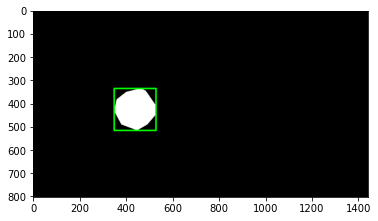

iteration: 2
threshold: 0.9799998807907104


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


usable bboxes: 625
outlier bboxes: 17


100%|██████████| 1/1 [00:33<00:00, 33.18s/it]


In [8]:
for ROI_margin_suffix in ROI_margin_suffix_list:
    for frame_rate_suffix in frame_rate_suffix_list:
        
        export_dir = export_dir_prefix + ROI_margin_suffix + '_' + frame_rate_suffix
        
        df = pd.read_excel(dataset_path, dtype=str)
        print(df.shape)
        
        for col in df.columns:
            if col.endswith('_path'):
                df.loc[:,col] = df[col].apply(add_data_dir, args=(data_dir,))
                
        for row_idx in tqdm(df.index):
            patient_code_inj = df.loc[row_idx, 'patient_code_inj']
            print(patient_code_inj)
            pickle_full_path = df.loc[row_idx, 'pickle_bmode_CE_gray_path']
            print(pickle_full_path)
            mp4_path = join(export_mp4_dir, patient_code_inj+'.mp4')
            nifti_segmentation_path = df.loc[row_idx, 'nifti_segmentation_path']

            full_array, bmode_MC_bboxes, ref_frames, ref_bboxes, ref_masks = perform_MC(pickle_full_path, 
                                                                                        nifti_segmentation_path, 
                                                                                        mp4_path,
                                                                                        ROI_margin_suffix, 
                                                                                        frame_rate_suffix)

            #resize all MC bboxes to the same size
            bmode_MC_bboxes = resize_MC_bboxes(bmode_MC_bboxes)

            #remove outlier bboxes
            bmode_MC_bboxes = remove_outlier_bboxes(bmode_MC_bboxes, full_array)

            n_frames = full_array.shape[0]

            x0_bmode = int(df.loc[row_idx, 'x0_bmode'])
            y0_bmode = int(df.loc[row_idx, 'y0_bmode'])
            w_bmode = int(df.loc[row_idx, 'w_bmode'])
            h_bmode = int(df.loc[row_idx, 'h_bmode'])
            x0_CE = int(df.loc[row_idx, 'x0_CE'])
            y0_CE = int(df.loc[row_idx, 'y0_CE'])
            w_CE = int(df.loc[row_idx, 'w_CE'])
            h_CE = int(df.loc[row_idx, 'h_CE'])
            CE_side = df.loc[row_idx, 'CE_window_left(l)_or_right(r)']

            CE_MC_bboxes = create_CE_MC_bboxes(bmode_MC_bboxes, x0_bmode, x0_CE, CE_side)
            bmode_ori_bboxes = create_ori_bboxes(ref_frames, ref_bboxes, n_frames).astype('int')
            CE_ori_bboxes = create_CE_ori_bboxes(bmode_ori_bboxes, x0_bmode, x0_CE, CE_side).astype('int')

            #cut ROI
            if not fixed_size_ROI:
                #use "cut_ROI" function to get ROI exactly fit to the lesion
                bmode_MC_ROI = cut_ROI(full_array, bmode_MC_bboxes)
                CE_MC_ROI = cut_ROI(full_array, CE_MC_bboxes)
            else:
                #use "cut_ROI200" function to get a fixed size ROI
                bmode_MC_ROI = cut_ROI200(full_array, bmode_MC_bboxes, (x0_bmode,y0_bmode,w_bmode,h_bmode))
                CE_MC_ROI = cut_ROI200(full_array, CE_MC_bboxes, (x0_CE,y0_CE,w_CE,h_CE))

            export_pickle(bmode_MC_ROI, join(export_dir, patient_code_inj, 'bmode_MC_ROI.pkl'))
            export_pickle(CE_MC_ROI, join(export_dir, patient_code_inj, 'CE_MC_ROI.pkl'))
            